# Imports

In [1]:
from algorithms.trace_the_best import TraceTheBest
import numpy as np
import sys

import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s | %(name)s (%(levelname)s):\t %(message)s')

# Testing Algorithm

In [2]:
ttb = TraceTheBest(rounds=1000, logger_level=logging.DEBUG)

In [3]:
ttb.run()


2022-10-09 19:40:19,771 | TraceTheBest (INFO):	 Running algorithm...
2022-10-09 19:40:19,772 | TraceTheBest (INFO):	 Iteration: 0
2022-10-09 19:40:19,773 | TraceTheBest (DEBUG):	     -> Running winner: 3
2022-10-09 19:40:19,773 | TraceTheBest (DEBUG):	     -> Actions: [ 7  2 15  6 18 10 19  5 16 12 17 14  9  4  0  3]
2022-10-09 19:40:19,773 | TraceTheBest (DEBUG):	     -> Subset: [ 8  1 11 13]
2022-10-09 19:40:19,774 | TraceTheBest (INFO):	 Starting Duels...
2022-10-09 19:40:19,814 | TraceTheBest (INFO):	 Duels finished...
2022-10-09 19:40:19,815 | TraceTheBest (DEBUG):	     -> Empirical winner: 7
2022-10-09 19:40:19,815 | TraceTheBest (INFO):	 self.subset.size < self.subset_size - 1
2022-10-09 19:40:19,817 | TraceTheBest (INFO):	 Iteration: 1
2022-10-09 19:40:19,817 | TraceTheBest (DEBUG):	     -> Running winner: 3
2022-10-09 19:40:19,817 | TraceTheBest (DEBUG):	     -> Actions: [19  6  7 14  9  2  4 10  0 18 12  3  8  1 11 13]
2022-10-09 19:40:19,817 | TraceTheBest (DEBUG):	     -> S

In [4]:
ttb.get_condorcet_winner()

3

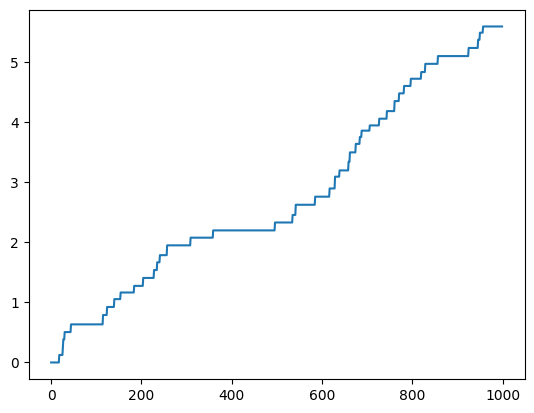

In [5]:
from util.metrics import compute_cumm_reg
import matplotlib.pyplot as plt

regrets = np.array(ttb.regret)
cummulative_regret = compute_cumm_reg(regrets)
plt.plot(np.mean(cummulative_regret, axis=0))
# plt.fill_between(range(len(cummulative_regret[0])), np.mean(cummulative_regret, axis=0)-np.std(cummulative_regret, axis=0)/np.sqrt(len(cummulative_regret)), np.mean(cummulative_regret, axis=0)+np.std(cummulative_regret, axis=0)/np.sqrt(len(cummulative_regret)), alpha=0.2)

In [22]:
ttb.theta_bar.reshape(-1,1)

array([[4.21326757e-01],
       [3.02127747e-01],
       [5.13350350e-01],
       [1.24387415e-01],
       [8.15539055e-01],
       [9.13461209e-01],
       [7.31561817e-01],
       [8.62751707e-01],
       [3.37572941e-01],
       [8.91219361e-01],
       [2.15942771e-01],
       [3.19334012e-01],
       [8.82131056e-01],
       [1.73629077e-01],
       [6.53976296e-01],
       [9.84691295e-01],
       [5.48826559e-01],
       [5.79401860e-01],
       [8.07384880e-01],
       [3.05671791e-01],
       [9.48739384e-01],
       [9.12234771e-01],
       [3.81104175e-01],
       [8.23038321e-01],
       [7.74246879e-02],
       [1.29390015e-01],
       [8.34577405e-01],
       [8.88791310e-01],
       [7.04209162e-01],
       [2.16123385e-02],
       [5.72768982e-01],
       [5.68132380e-01],
       [5.95087821e-02],
       [1.58091208e-01],
       [6.93523689e-01],
       [4.63345814e-01],
       [9.75033924e-01],
       [7.03590432e-01],
       [8.36369326e-01],
       [3.28849397e-01],


# Testing reading of features and running times

In [33]:
import csv 
import re
import os
from pathlib import Path
import numpy as np
from sklearn import preprocessing
import pandas as pd


In [34]:
running_times_file = os.path.join(f'{Path.cwd()}', 'Data_saps_swgcp_reduced\cpu_times_inst_param.csv')
running_times = []
with open(running_times_file, newline='') as csvfile:
    running_times_data = list(csv.reader(csvfile))

for i in range(1, len(running_times_data)):
    next_line = running_times_data[i][0]
    next_rt_vector = [float(s) for s in re.findall(r'-?\d+\.?\d*', next_line)][2:]
    running_times.append(next_rt_vector)
running_times = np.asarray(running_times)
lambda_ = 100
running_times = np.exp(-lambda_ * running_times)

In [35]:
running_times.shape

(5000, 20)

In [36]:
parametrizations_file = os.path.join(f'{Path.cwd()}', 'Data_saps_swgcp_reduced\Random_Parameters_SAPS.txt')
with open(parametrizations_file, "r") as f:
    lineList = f.readlines()
parametrizations = [float(s) for s in re.findall(r'-?\d+\.?\d*', lineList[0])]
parametrizations = np.reshape(parametrizations, (20, 4))
parametrizations = preprocessing.normalize(parametrizations)
parametrizations.shape

(20, 4)

In [37]:
from sklearn.feature_selection import VarianceThreshold

# read features
features_file = os.path.join(
        f"{Path.cwd()}",
        os.path.join("Data_saps_swgcp_reduced", "Reduced_Features_SWGCP_only_5000.csv"),
    )

features = []
instances = []
with open(features_file, newline='') as csvfile:
    features_data = list(csv.reader(csvfile))
for i in range(1, len(features_data)):
    next_line = features_data[i]
    instances.append(next_line[0])
    del next_line[0]
    next_feature_vector = [float(s) for s in next_line]
    features.append(next_feature_vector)
features = np.asarray(features)
# normalize#########
min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(features)
# Drop Highly Correlated Features #######
df = pd.DataFrame(features)
# Create correlation matrix
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
# Drop features 
df.drop(df[to_drop], axis=1, inplace=True)
features = df.to_numpy()
# Drop features with lower variance
selector = VarianceThreshold(0.001)
features = selector.fit_transform(features)
features.shape

(5000, 8)

In [ ]:
from util.utility_functions import random_sample_from_list

round_1 = random_sample_from_list(array=instances, size=100, random_state=np.random.RandomState())

In [ ]:
round_2 = random_sample_from_list(array=instances, exclude=round_1 ,size=100, random_state=np.random.RandomState())

In [ ]:
round_2 == round_1

In [ ]:
set(array) - set(exclude)

In [ ]:
np.where(array == exclude)

In [ ]:
np.argwhere(array == exclude)

In [ ]:
len(instances)

In [ ]:
n = parametrizations.shape[0]
d = parametrizations.shape[1] * features.shape[1]
theta_init = np.random.rand(d)

Xs = []
for t in range(features.shape[0]):
    X = np.zeros((n, d))
    next_context = features[t, :]
    for i in range(n):
        next_param = parametrizations[i]
        X[i, :] = np.kron(parametrizations[i], next_context)
    #        X[i,:] = np.concatenate((next_param,next_context), axis=0)
    #    X = preprocessing.normalize(X)
    #    min_max_scaler = preprocessing.MinMaxScaler()
    #    X = min_max_scaler.fit_transform(X)
    Xs.append(X)
Xs = np.array(Xs)
Xs.shape

In [ ]:
S = np.random.choice(parametrizations.shape[0], 16, replace=False)
rt = running_times[0, :]
true_skills = rt[S]
true_skills

In [ ]:
rt

In [ ]:
running_times